# Lab 4: Adversarial Training with MNIST

In [1]:
import os
import sys
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torchattacks
from torchattacks import RPGD, FGSM
import time

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 1. Dataset Preparation and DNN Trainin

### 1.1 MNIST Dataset

In [3]:
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:01, 5574585.56it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


32768it [00:00, 276062.77it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 5005284.00it/s]                           
8192it [00:00, 169280.64it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


In [4]:
batch_size = 128

train_loader  = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                         batch_size=batch_size,
                                         shuffle=False)

### 1.2 Define Model

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,5),
            nn.ReLU(),
            nn.Conv2d(16,32,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*3*3,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )       
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(-1,64*3*3)
        out = self.fc_layer(out)

        return out

In [6]:
model = CNN().to(device)
if device =='cuda':
    print("Train on GPU...")
else:
    print("Train on CPU...")

Train on GPU...


In [7]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 1.3 Normal training

In [8]:
num_epochs = 5
print('start training')
start = time.time()
for epoch in range(num_epochs):
    total_batch = len(mnist_train) // batch_size
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        X = batch_images.to(device)
        Y = batch_labels.to(device)
        pre = model(X)
        cost = loss(pre, Y)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))
print('training finished')
end = time.time()
print ('the total running time is:', end - start)
torch.save(model.state_dict(),'normal_model.pt')

start training
Epoch [1/5], lter [100/468], Loss: 0.2202
Epoch [1/5], lter [200/468], Loss: 0.1322
Epoch [1/5], lter [300/468], Loss: 0.0873
Epoch [1/5], lter [400/468], Loss: 0.0469
Epoch [2/5], lter [100/468], Loss: 0.0375
Epoch [2/5], lter [200/468], Loss: 0.1059
Epoch [2/5], lter [300/468], Loss: 0.0568
Epoch [2/5], lter [400/468], Loss: 0.0073
Epoch [3/5], lter [100/468], Loss: 0.0249
Epoch [3/5], lter [200/468], Loss: 0.1035
Epoch [3/5], lter [300/468], Loss: 0.0458
Epoch [3/5], lter [400/468], Loss: 0.0053
Epoch [4/5], lter [100/468], Loss: 0.0111
Epoch [4/5], lter [200/468], Loss: 0.0908
Epoch [4/5], lter [300/468], Loss: 0.0452
Epoch [4/5], lter [400/468], Loss: 0.0029
Epoch [5/5], lter [100/468], Loss: 0.0065
Epoch [5/5], lter [200/468], Loss: 0.0918
Epoch [5/5], lter [300/468], Loss: 0.0331
Epoch [5/5], lter [400/468], Loss: 0.0022
training finished
the total running time is: 31.159525156021118


### 1.4 Accuracy on clean images

In [10]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.to(device)
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of Clean images: %f %%' % (100 * float(correct) / total))

Accuracy of Clean images: 98.510000 %


## 2. Generating adversarial examples

tensor([7, 2, 1, 0, 4], device='cuda:0')
tensor([7, 2, 1, 0, 9], device='cuda:0')


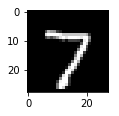

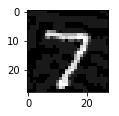

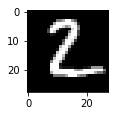

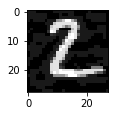

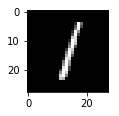

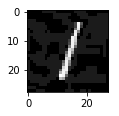

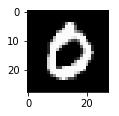

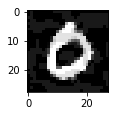

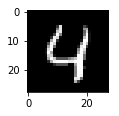

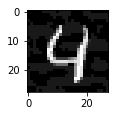

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline


model = CNN().to(device)
model.load_state_dict(torch.load("normal_model.pt"))
fgsm_attack = FGSM(model, eps=0.1)

images, labels = next(iter(test_loader))
images = images[:5].to(device)
labels = labels[:5].to(device)
adver_images = fgsm_attack(images, labels).to(device)

outputs = model(adver_images)
_, predicted = torch.max(outputs.data, 1)
print(labels)
print(predicted)
for i,_ in enumerate(labels):
    plt.figure(figsize=(1.5,1.5))
    plt.imshow(images[i][0].cpu().detach().numpy(), cmap='gray')
    plt.figure(figsize=(1.5,1.5))
    plt.imshow(adver_images[i][0].cpu().detach().numpy(), cmap='gray')

## 3. Accuracy under Adversarial Attacks

### 3.1 FGSM

In [28]:
model.eval()

start_time = time.time()
for i in range(0,32,2):

    correct = 0
    total = 0

    fgsm_attack = FGSM(model,eps=i/100)#0.2)

    for images, labels in test_loader:

        images = fgsm_attack(images, labels).to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()

    print('Accuracy of Adversarial images: %f %%' % (100 * float(correct) / total), "eps =",i/100)
print("Runtime (ticks) =", time.time() - start_time)

Accuracy of Adversarial images: 98.510000 % eps = 0.0
Accuracy of Adversarial images: 97.250000 % eps = 0.02
Accuracy of Adversarial images: 95.510000 % eps = 0.04
Accuracy of Adversarial images: 92.740000 % eps = 0.06
Accuracy of Adversarial images: 89.160000 % eps = 0.08
Accuracy of Adversarial images: 84.080000 % eps = 0.1
Accuracy of Adversarial images: 78.340000 % eps = 0.12
Accuracy of Adversarial images: 71.080000 % eps = 0.14
Accuracy of Adversarial images: 62.830000 % eps = 0.16
Accuracy of Adversarial images: 54.040000 % eps = 0.18
Accuracy of Adversarial images: 45.550000 % eps = 0.2
Accuracy of Adversarial images: 38.010000 % eps = 0.22
Accuracy of Adversarial images: 31.620000 % eps = 0.24
Accuracy of Adversarial images: 26.710000 % eps = 0.26
Accuracy of Adversarial images: 22.920000 % eps = 0.28
Accuracy of Adversarial images: 19.680000 % eps = 0.3
Runtime (ticks) = 17.833423614501953


### 3.2 PGD

In [29]:
model.eval()

start_time = time.time()
for i in range(0,32,2):
    correct = 0
    total = 0

    pgd_attack = RPGD(model,eps=i/100)#0.2)

    for images, labels in test_loader:

        images = pgd_attack(images, labels).to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()

    print('Accuracy of Adversarial images: %f %%' % (100 * float(correct) / total), "eps =",i/100)
print("Runtime (ticks) =", time.time() - start_time)

Accuracy of Adversarial images: 98.510000 % eps = 0.0
Accuracy of Adversarial images: 97.230000 % eps = 0.02
Accuracy of Adversarial images: 95.280000 % eps = 0.04
Accuracy of Adversarial images: 91.780000 % eps = 0.06
Accuracy of Adversarial images: 86.020000 % eps = 0.08
Accuracy of Adversarial images: 77.420000 % eps = 0.1
Accuracy of Adversarial images: 65.180000 % eps = 0.12
Accuracy of Adversarial images: 49.330000 % eps = 0.14
Accuracy of Adversarial images: 34.880000 % eps = 0.16
Accuracy of Adversarial images: 23.820000 % eps = 0.18
Accuracy of Adversarial images: 15.280000 % eps = 0.2
Accuracy of Adversarial images: 9.110000 % eps = 0.22
Accuracy of Adversarial images: 5.100000 % eps = 0.24
Accuracy of Adversarial images: 2.660000 % eps = 0.26
Accuracy of Adversarial images: 1.350000 % eps = 0.28
Accuracy of Adversarial images: 0.630000 % eps = 0.3
Runtime (ticks) = 157.01905417442322


## 4. Train Model using adversarial training

### 4.1 Training with PGD

In [36]:
num_epochs = 5
model = CNN().to(device)
pgd_attack = RPGD(model, eps=0.2, iters=20)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [37]:
print('start training')
model.train()
start = time.time()
for epoch in range(num_epochs):
    total_batch = len(mnist_train) // batch_size
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        X = pgd_attack(batch_images, batch_labels).to(device)
        Y = batch_labels.to(device)
        pre = model(X)
        cost = loss(pre, Y)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))
print('training finished')
end = time.time()
print ('the total running time is:', end - start)
torch.save(model.state_dict(),'adver_training_model.pt')

start training
Epoch [1/5], lter [100/468], Loss: 1.2008
Epoch [1/5], lter [200/468], Loss: 0.6103
Epoch [1/5], lter [300/468], Loss: 0.7436
Epoch [1/5], lter [400/468], Loss: 0.4729
Epoch [2/5], lter [100/468], Loss: 0.4027
Epoch [2/5], lter [200/468], Loss: 0.3476
Epoch [2/5], lter [300/468], Loss: 0.4655
Epoch [2/5], lter [400/468], Loss: 0.2379
Epoch [3/5], lter [100/468], Loss: 0.3272
Epoch [3/5], lter [200/468], Loss: 0.2831
Epoch [3/5], lter [300/468], Loss: 0.3523
Epoch [3/5], lter [400/468], Loss: 0.2059
Epoch [4/5], lter [100/468], Loss: 0.2831
Epoch [4/5], lter [200/468], Loss: 0.2518
Epoch [4/5], lter [300/468], Loss: 0.3131
Epoch [4/5], lter [400/468], Loss: 0.1490
Epoch [5/5], lter [100/468], Loss: 0.2391
Epoch [5/5], lter [200/468], Loss: 0.2216
Epoch [5/5], lter [300/468], Loss: 0.2617
Epoch [5/5], lter [400/468], Loss: 0.1131
training finished
the total running time is: 169.56827402114868


### 4.2 Test on clean images

In [38]:
model = CNN().to(device)
model.load_state_dict(torch.load("adver_training_model.pt"))
model.eval()
correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.to(device)
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of Clean images: %f %%' % (100 * float(correct) / total))

Accuracy of Clean images: 98.800000 %


## 5. Test on Adversarial images

In [41]:
model = CNN().to(device)
model.load_state_dict(torch.load("adver_training_model_eps=0.05.pt"))
model.eval()

for i in range(0,32,2):
    correct = 0
    total = 0

    pgd_attack = RPGD(model,eps=i/100)#0.2)

    for images, labels in test_loader:

        images = pgd_attack(images, labels).to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()

    print('Accuracy of Adversarial images: %f %%' % (100 * float(correct) / total), "eps =",i/100)

Accuracy of Adversarial images: 99.000000 % eps = 0.0
Accuracy of Adversarial images: 98.620000 % eps = 0.02
Accuracy of Adversarial images: 98.160000 % eps = 0.04
Accuracy of Adversarial images: 97.430000 % eps = 0.06
Accuracy of Adversarial images: 96.110000 % eps = 0.08
Accuracy of Adversarial images: 94.580000 % eps = 0.1
Accuracy of Adversarial images: 92.080000 % eps = 0.12
Accuracy of Adversarial images: 88.140000 % eps = 0.14
Accuracy of Adversarial images: 82.020000 % eps = 0.16
Accuracy of Adversarial images: 73.810000 % eps = 0.18
Accuracy of Adversarial images: 63.000000 % eps = 0.2
Accuracy of Adversarial images: 49.160000 % eps = 0.22
Accuracy of Adversarial images: 34.940000 % eps = 0.24
Accuracy of Adversarial images: 23.430000 % eps = 0.26
Accuracy of Adversarial images: 15.380000 % eps = 0.28
Accuracy of Adversarial images: 10.050000 % eps = 0.3
